In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
sns.set()

In [2]:
raw_train = pd.read_csv('train.csv')
raw_test = pd.read_csv('test.csv')
titanic_train = pd.read_csv('train.csv')
titanic_test = pd.read_csv('test.csv')

# Exploratory Analysis

In [3]:
titanic_train.head()
# Survived: 0 = No, 1 = Yes
# Pclass: Ticket Class
# Sibsp: Number of siblings or spouses aboard the Titanic
# Parch: Number of parents or children aboard the Titanic
# Ticket: Ticket Number
# Cabin: Cabin Number
# Embarked: Where the passenger embarked. C = Cherbourg, Q = Queenstown, S = Southampton

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The first step is to explore some basic characteristics of our dataset to determine what may or may not be useful in the creation of our model.

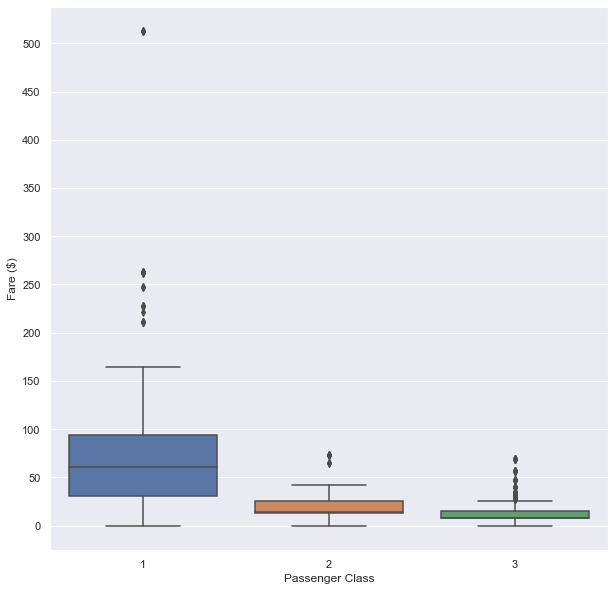

In [4]:
fig = plt.figure(figsize = (10,10))
sns.boxplot(x = 'Pclass', y = 'Fare', orient = 'v', data = titanic_train)
plt.xlabel('Passenger Class')
plt.ylabel('Fare ($)')
plt.yticks(np.arange(0,550,50))
plt.show()

For all three social classes, the bulk of values sit below $ 50-100. However, there are quite a few outliers in all three social classes. It would be interesting to see how a higher fare might influence survival likelihood (for example, perhaps it would indicate preferential cabin placement closer to the deck, which would make it easier to evacuate). 

Next, it would be interesting to see a the distribution of survivors based on age and sex. 

In [5]:
df_survivors = titanic_train[(titanic_train.Survived == 1)]
df_survivors.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


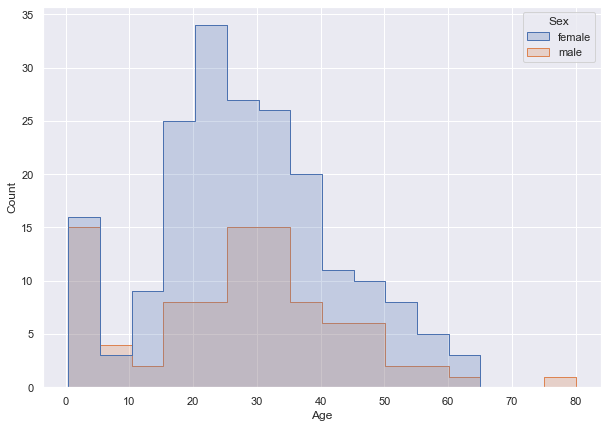

In [6]:
plt.figure(figsize = (10,7))
sns.histplot(x = 'Age', hue = 'Sex', element = 'step', data = df_survivors)
plt.show()

We see a multimodal histogram when examining the count of survivors from age. We see the first peak between 0-5 years of age. These are likely passengers who would be cared for and heavily supervised by older passengers.  The distributions sees a secondary peak between 20 and 30 years of age, which gradually descends as passengers get older.

The histogram also shows that far fewer men survived than women in age-ranges greater than 15-20 years of age. The distribution is really a testament to the statement 'women and children first'.

# Feature Engineering

In this next section, we will take a look at some new features we can create from the existing variables in the dataset.

First, our column cabin won't really be useful in our model. However, the cabin column contains information about which deck the passengers were located on. This can be done by extracting the first letter from the cabin column.

The Titanic had 10 decks in total, however passenger decks were located on decks B to G.

This could be useful information, since it could be more difficult for a passenger to evacuate if they were located on a lower deck.

In [7]:
titanic_train['Deck'] = titanic_train['Cabin'].str[0]
titanic_train['Deck'] = titanic_train['Deck'].fillna('Unknown')
titanic_train.head()
#Same for test data:
titanic_test['Deck'] = titanic_test['Cabin'].str[0]
titanic_test['Deck'] = titanic_test['Deck'].fillna('Unknown')

Another interesting feature to create would be family size. 

This can easily be done by adding the columns SibSp and Parch (Siblings, Spouses, Parents, Children) together.

In [8]:
titanic_train['FamilySize'] = titanic_train['SibSp'] + titanic_train['Parch']
titanic_train.head()
#Same for test data:
titanic_test['FamilySize'] = titanic_test['SibSp'] + titanic_test['Parch']

Finally, another interesting piece of information to look at would be the passenger's title. This can be extracted from the Name attribute.

In [9]:
titanic_train[['LastName','FirstName']] = titanic_train['Name'].str.split(', ',expand = True)
titanic_train['Title'] = titanic_train['FirstName'].str.split('.').str[0]
titanic_train = titanic_train.drop(['FirstName','LastName'], axis = 1)
titanic_train.head()
#Same for test data:
titanic_test[['LastName','FirstName']] = titanic_test['Name'].str.split(', ',expand = True)
titanic_test['Title'] = titanic_test['FirstName'].str.split('.').str[0]
titanic_test = titanic_test.drop(['FirstName','LastName'], axis = 1)

These values might need to be grouped into a smaller number of more meaningful categories to be useful. I will revisit this later.

# Preprocessing The Data

Before we start building our model, we have to preprocess the data to avoid later issues.
We will start by examining null values in our dataset.

In [10]:
titanic_train.isnull().sum(axis = 0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Deck             0
FamilySize       0
Title            0
dtype: int64

First, Embarked only has 2 null values. Since there won't be much data loss and accurate values are impossible to impute, we will just drop those rows.

In [11]:
titanic_train = titanic_train[titanic_train['Embarked'].notna()]
titanic_train.isnull().sum(axis = 0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Deck             0
FamilySize       0
Title            0
dtype: int64

In [12]:
# Doing the same for the test data. Embarked has 0 null values.
titanic_test.isnull().sum(axis = 0)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Deck             0
FamilySize       0
Title            0
dtype: int64

Next, I want to restrict my training data to only relevant variables. For the purposes of this analysis, I will be removing PassengerId and Name. I will also be removing Cabin, as any relevant information is displayed by the newly created 'Deck' variable

In [13]:
titanic_train = titanic_train.drop(['PassengerId','Name','Cabin'], axis = 1)
#Same for the test data
titanic_test = titanic_test.drop(['PassengerId','Name','Cabin'], axis = 1)

Next, I will handle the remainder of missing values, which occur in the age category. I'll start again by taking a look at the distribution of ages in our dataset to determine whether imputation of the mean or median is most appropriate for this variables

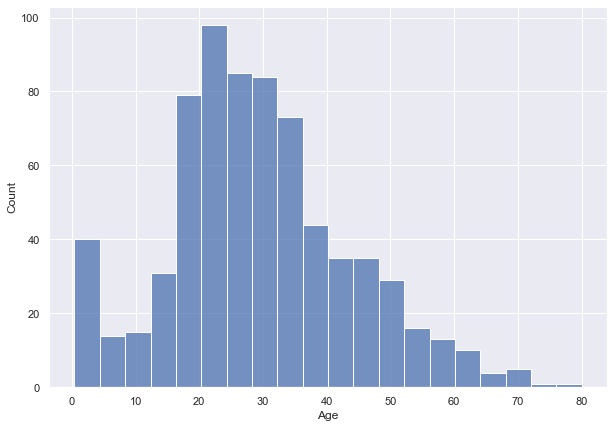

In [14]:
plt.figure(figsize = (10,7))
sns.histplot(x = 'Age', data = titanic_train)
plt.show()

The distribution is right skewed, with the bulk of values laying on the left of the histogram. This means that we will have a number of high value outliers that will inflate the mean. Therefore, because the distribution is so right skewed, I think that it would be more accurate to impute age with the median value than then the mean.

In [15]:
titanic_train['Age'].fillna(titanic_train['Age'].median(), inplace = True)
titanic_train.isnull().sum(axis = 0)
#Test Data:
titanic_test['Age'].fillna(titanic_test['Age'].median(), inplace = True)

I also want to examine the distribution of fare to see if it would benefit from normalization.

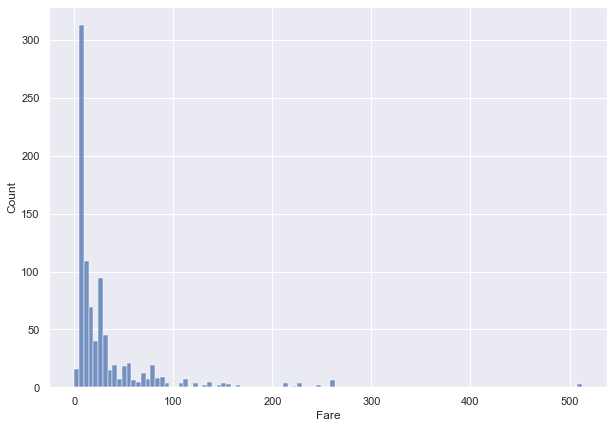

In [16]:
plt.figure(figsize = (10,7))
sns.histplot(x = 'Fare', data = titanic_train)
plt.show()

The distribution of fare is extremely right skewed. Therefore, I will try log transforming fare in an effort to later reduce the overall error of the model's predictions.

Note: I could not find a conclusive answer regarding 0 fare values online. 

I know that at least some of the 0 values were crew members who boarded in Southhampton and I do not have an explanation for the ones who were not crew members. Therefore, I don't feel entirely comfortable with completely removing or imputing the $0 values.

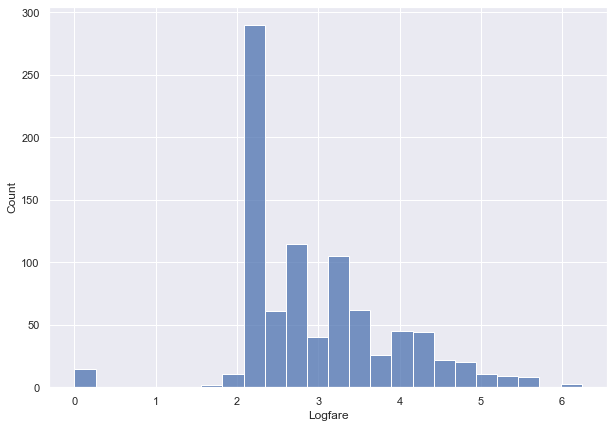

In [17]:
#Log + 1 to avoid divide by zero error
titanic_train['Logfare'] = np.log(titanic_train['Fare']+1)
plt.figure(figsize = (10,7))
sns.histplot(x = 'Logfare', data = titanic_train)
plt.show()
#Test data:
titanic_test['Logfare'] = np.log(titanic_test['Fare']+1)

This produces a more normalized version of fare that will likely be more useful in our model.

Next, I need to encode all categorical variables in my dataset in order to use them. I will be using One Hot Encoding for this project. 

We will use One Hot Encoding because normal Label Encoding assumes an ordinal relationship between levels in a given categorical column, which can lead to poor performance on the model. One Hot Encoding eliminates this problem by creating dummy variables for each level of a given categorical variable.

In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
#Initialize with drop = 'first' to avoid perfect multicolinearity between dummy variables. 
ohe = OneHotEncoder(categories = 'auto', drop = 'first', sparse = False)

ohe_titanic_train = pd.DataFrame(ohe.fit_transform(titanic_train[['Pclass','Sex','Age','SibSp','Parch','Ticket','Embarked','Deck','FamilySize','Title']]))
dummy_names = ohe_titanic_train.columns.values
feature_names = ohe.get_feature_names_out()

col_rename_dict = {i:j for i,j in zip(dummy_names,feature_names)}
ohe_titanic_train.rename(columns=col_rename_dict, inplace = True)
ohe_titanic_train.head()

,Pclass_2,Pclass_3,Sex_male,Age_0.67,Age_0.75,Age_0.83,Age_0.92,Age_1.0,Age_2.0,Age_3.0,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [20]:
#Test Data:
ohe = OneHotEncoder(categories = 'auto', drop = 'first', sparse = False)
ohe_titanic_test = pd.DataFrame(ohe.fit_transform(titanic_test[['Pclass','Sex','Age','SibSp','Parch','Ticket','Embarked','Deck','FamilySize','Title']]))
test_dummy_names = ohe_titanic_test.columns.values
test_feature_names = ohe.get_feature_names_out()

test_col_rename_dict = {i:j for i,j in zip(test_dummy_names,test_feature_names)}
ohe_titanic_test.rename(columns=test_col_rename_dict, inplace = True)

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
titanic_train['Logfare'].shape
fare_reshape = np.array(titanic_train['Logfare']).reshape(-1,1)
scaler.fit(fare_reshape)
logfare_scaled = scaler.transform(fare_reshape)

In [22]:
ohe_titanic_train['Survived'] = titanic_train['Survived']
ohe_titanic_train['LogfareScaled'] = logfare_scaled

In [23]:
#Test Data
test_logfare_scaled = scaler.transform(np.array(titanic_test['Logfare']).reshape(-1,1))
ohe_titanic_test['LogfareScaled'] = test_logfare_scaled

In [24]:
ohe_titanic_train = ohe_titanic_train.loc[np.isnan(ohe_titanic_train['Survived']) == False]

In [25]:
x_train = ohe_titanic_train.drop(['Survived'],axis = 1)
y_train = ohe_titanic_train['Survived']

# Building The Model

For the purposes of my first machine learning project, I will be using an logistic regression. We will start by using all features in our dataframe to predict survival

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,test_size = 0.33,random_state = 42)

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
lgm = LogisticRegression()
lgm.fit(x_train,y_train)

LogisticRegression()

In [30]:
predictions = lgm.predict(x_test)

In [31]:
from sklearn.metrics import classification_report

In [32]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.60      0.85      0.70       174
         1.0       0.43      0.17      0.24       119

    accuracy                           0.57       293
   macro avg       0.52      0.51      0.47       293
weighted avg       0.53      0.57      0.52       293



As we can see, this model is barely better than a coinflip. It was able to predict survival correctly 57% of the time. Now we will perform feature selection

In [33]:
from featurewiz import featurewiz

Imported featurewiz. Version = 0.1.13. nrows=None uses all rows. Set nrows=1000 to randomly sample 1000 rows.
outputs = featurewiz(dataname, target, corr_limit=0.70, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']
                                


In [34]:
target = 'Survived'
titanic_train['LogfareScaled'] = logfare_scaled
titanic_train = titanic_train.drop(['Logfare','Fare'], axis = 1)

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Skipping feature engineering since no feature_engg input...
**INFO: featurewiz can now read feather formatted files. Loading train data...
    Shape of your Data Set loaded: (889, 12)
    Caution: We will try to reduce the memory usage of dataframe from 0.12 MB
        memory usage after optimization is: 0.07 MB
        decreased by 38.8%
     Loaded. Shape = (889, 12)
No test data filename given...
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    11 Predictors classified...
        No variables removed since no ID or low-information variables found in

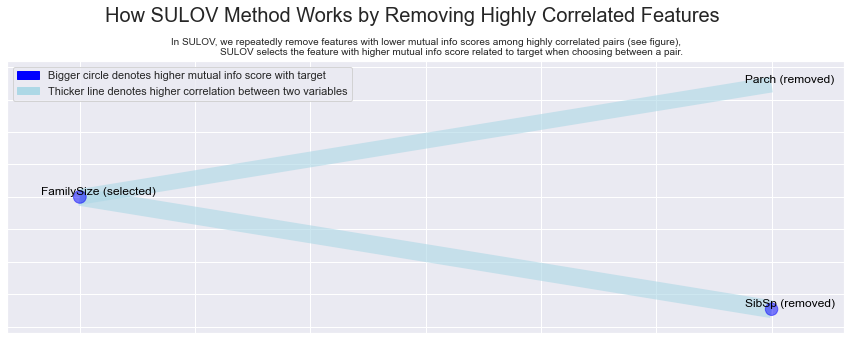

Time taken for SULOV method = 0 seconds
    Adding 4 categorical variables to reduced numeric variables  of 5
Final list of selected vars after SULOV = 9
############## F E A T U R E   S E L E C T I O N  ####################
    using regular XGBoost
Train and Test loaded into Dask dataframes successfully after feature_engg completed
Since  category encoding is done, dropping original categorical vars from predictors...
Current number of predictors = 5 
    XGBoost version: 1.5.2
Number of booster rounds = 100
        using 5 variables...
            Time taken for regular XGBoost feature selection = 0 seconds
        using 3 variables...
            Time taken for regular XGBoost feature selection = 0 seconds
        using 1 variables...
            Time taken for regular XGBoost feature selection = 0 seconds


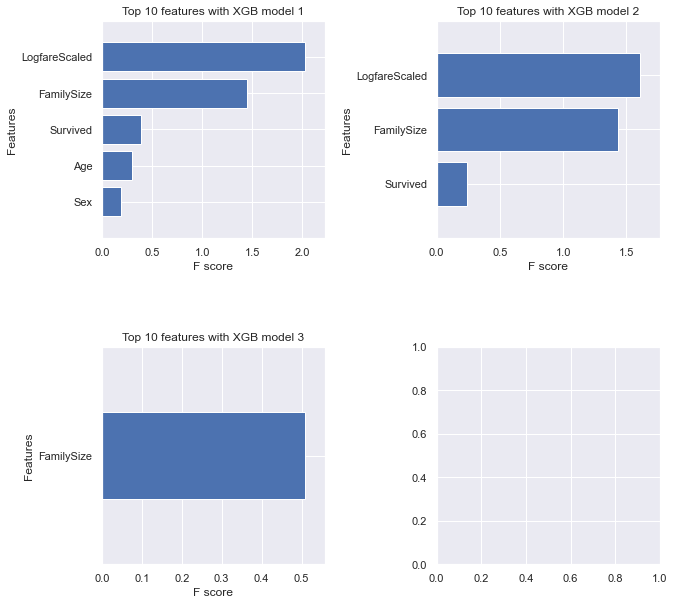

            Total time taken for XGBoost feature selection = 1 seconds
No ID variables [] are selected since they are not considered important for modeling
Selected 5 important features:
['LogfareScaled', 'FamilySize', 'Survived', 'Age', 'Sex']
    Time taken = 1 seconds
    Reverted column names to original names given in train dataset
Returning list of 5 important features and a dataframe.


In [36]:
features, train = featurewiz(titanic_train, target,corr_limit = 0.7, verbose = 2, sep=',',header=0,
                             test_data ='',feature_engg='',category_encoders='OneHotEncoder')

['LogfareScaled', 'FamilySize', 'Survived', 'Age', 'Sex'] will be used for our final model

In [37]:
X_new = train.drop('Survived', axis = 1)
y = train['Survived']

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X_new, y, test_size = 0.33, random_state = 42)

In [39]:
lgm = lgm = LogisticRegression()
lgm.fit(X_train,y_train)

LogisticRegression()

In [40]:
predictions = lgm.predict(X_valid)

In [42]:
print(classification_report(y_valid, predictions))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85       184
           1       0.73      0.77      0.75       110

    accuracy                           0.81       294
   macro avg       0.80      0.80      0.80       294
weighted avg       0.81      0.81      0.81       294

